# Stage 1 — Exploratory Data Analysis

STAGE ALIGNMENT:
Input:
Output:
Next Stage Dependency:

## 1. Raw Data File Structure

Purpose:
To understand the file format, structure, and size of the dataset before loading.
This ensures correct loading strategy and prevents memory or parsing errors.

In [1]:
from pathlib import Path
import pandas as pd

RAW_PATH = Path("../Data/raw")
files = list(RAW_PATH.glob("*"))

file_info = []

for f in files:
    file_info.append({
        "file_name": f.name,
        "extension": f.suffix,
        "size_MB": round(f.stat().st_size / (1024**2), 2)
    })

file_df = pd.DataFrame(file_info)
file_df


,file_name,extension,size_MB
0,.gitkeep,,0.00
1,sepsisexp_timeseries_partition-A.tsv,.tsv,74.14
2,sepsisexp_timeseries_partition-B.tsv,.tsv,71.97
3,sepsisexp_timeseries_partition-C.tsv,.tsv,73.95
4,sepsisexp_timeseries_partition-D.tsv,.tsv,65.12


## 2. Structural Preview (Single Partition)

Purpose:
To inspect column names, datatypes, and row structure before merging all partitions.

In [2]:
sample_file = RAW_PATH / "sepsisexp_timeseries_partition-A.tsv"

df_sample = pd.read_csv(sample_file, sep="\t")

print("Shape:", df_sample.shape)
print("\nColumns:")
print(df_sample.columns.tolist())

df_sample.head()

Shape: (156704, 47)

Columns:
['id', 'sepsis', 'severity', 'timestep', 'respiratory_minute_volume', 'heart_rate', 'leukocytes', 'temperature', 'partial_co2', 'respiratory_rate', 'arterial_ph', 'bilirubin', 'blood_urea_nitrogen', 'creatinine', 'diastolic_bp', 'fraction_of_inspired_o2', 'mean_bp', 'partial_pressure_art._o2', 'systolic_bp', 'thrombocytes', 'horowitz_index', 'bun/creatinine_ratio', 'delta-temperature', 'lactate', 'bicarbonate', 'c-reactive_protein', 'hemoglobin', 'heart_time_volume', 'lymphocytes', 'sodium', 'pancreatic_lipase', 'procalcitonin', 'quick_score', 'oxygen_saturation', 'blood_glucose', 'base_excess', 'chloride', 'calcium', 'potassium', 'mixed_venous_oxygen_saturation', 'urine_output', 'net balance', 'alanine_transaminase', 'aspartate_transaminase', 'stroke_volume', 'svri', 'age']


,id,sepsis,severity,timestep,respiratory_minute_volume,heart_rate,leukocytes,temperature,partial_co2,respiratory_rate,...,calcium,potassium,mixed_venous_oxygen_saturation,urine_output,net balance,alanine_transaminase,aspartate_transaminase,stroke_volume,svri,age
0,12292,0,0.0,0.0,0.190898,0.424464,0.301015,-0.168117,-0.275272,1.879692,...,1.019083,-0.334653,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047
1,12292,0,0.0,0.5,0.157654,0.667394,0.301015,-0.168117,-0.275272,1.708485,...,1.019083,-0.334653,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047
2,12292,0,0.0,1.0,0.024678,0.618808,0.301015,-0.732387,1.003408,2.050899,...,-0.868157,2.923028,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047
3,12292,0,0.0,1.5,-0.208030,0.278706,0.301015,-0.732387,1.003408,1.366071,...,-0.868157,2.923028,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047
4,12292,0,0.0,2.0,-0.108298,-0.352912,0.301015,-0.732387,1.094023,1.537278,...,-0.868157,2.719423,0.010733,-0.710447,0.452120,-0.023852,0.117472,0.317126,0.061715,0.371047


## 3. Patient Structure & Sepsis Label Behavior

Purpose:
To understand how many patients exist, how many timesteps per patient,
and how the sepsis label behaves across time.

In [3]:
# Unique patients
n_patients = df_sample['id'].nunique()

# Rows per patient
rows_per_patient = df_sample.groupby('id').size()

# Sepsis label distribution
sepsis_counts = df_sample['sepsis'].value_counts()

print("Number of unique patients:", n_patients)
print("\nRows per patient summary:")
print(rows_per_patient.describe())

print("\nSepsis label distribution:")
print(sepsis_counts)

Number of unique patients: 319

Rows per patient summary:
count     319.000000
mean      491.235110
std       759.746605
min        32.000000
25%        60.000000
50%       212.000000
75%       563.000000
max      5363.000000
dtype: float64

Sepsis label distribution:
sepsis
1    95071
0    61633
Name: count, dtype: int64


In [4]:
def check_flip(group):
    return group['sepsis'].diff().fillna(0).abs().sum()

flip_counts = df_sample.groupby('id').apply(check_flip)

print("Patients with label change:", (flip_counts > 0).sum())
print("Patients without label change:", (flip_counts == 0).sum())


Patients with label change: 0
Patients without label change: 319


C:\Users\Hope\AppData\Local\Temp\ipykernel_31028\2926490868.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flip_counts = df_sample.groupby('id').apply(check_flip)


### Structural Summary

This partition contains 319 unique patients.

Timesteps per patient vary significantly:
- Mean ≈ 491
- Median ≈ 212
- Minimum = 32
- Maximum = 5363

This indicates highly unequal monitoring durations, with some patients observed
briefly and others over very long trajectories.

Row-level sepsis distribution:
- Sepsis = 1: 95,071
- Sepsis = 0: 61,633

The dataset is not strongly imbalanced at the row level in this partition.

However, label transition analysis shows:
- 0 patients exhibit a sepsis label change over time.
- 319 patients maintain a constant label.

This implies that within this partition, sepsis appears to be a patient-level label,
not a timestep-level onset signal.

### Modeling Implication

If this structure holds across other partitions, the task may not involve
detecting the exact onset moment within a trajectory,
but rather distinguishing septic from non-septic patients.

The large variability in observation length may introduce bias,
as patients with longer monitoring contribute more rows to the dataset.

Further investigation across all partitions is required before defining
how sepsis onset should be operationalized for 2h, 4h, and 6h prediction.

In [5]:
# Load Partition B
file_B = RAW_PATH / "sepsisexp_timeseries_partition-B.tsv"
df_B = pd.read_csv(file_B, sep="\t")

print("Shape:", df_B.shape)

# Unique patients
n_patients_B = df_B['id'].nunique()

# Rows per patient
rows_per_patient_B = df_B.groupby('id').size()

# Sepsis label distribution
sepsis_counts_B = df_B['sepsis'].value_counts()

print("\nNumber of unique patients:", n_patients_B)
print("\nRows per patient summary:")
print(rows_per_patient_B.describe())

print("\nSepsis label distribution:")
print(sepsis_counts_B)

# Check label flip behavior
def check_flip(group):
    return group['sepsis'].diff().fillna(0).abs().sum()

flip_counts_B = df_B.groupby('id').apply(check_flip)

print("\nPatients with label change:", (flip_counts_B > 0).sum())
print("Patients without label change:", (flip_counts_B == 0).sum())

Shape: (152155, 47)

Number of unique patients: 319

Rows per patient summary:
count     319.000000
mean      476.974922
std       671.111417
min        32.000000
25%        60.000000
50%       219.000000
75%       657.500000
max      5424.000000
dtype: float64

Sepsis label distribution:
sepsis
1    92732
0    59423
Name: count, dtype: int64

Patients with label change: 0
Patients without label change: 319


C:\Users\Hope\AppData\Local\Temp\ipykernel_31028\842965218.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flip_counts_B = df_B.groupby('id').apply(check_flip)


### Structural Consistency Across Partitions A and B

Both partitions contain:
- 319 unique patients each.
- Similar timestep distributions (mean ≈ 480–490 rows per patient).
- Large variability in monitoring duration (min = 32, max > 5000 timesteps).

Row-level sepsis distribution:
Partition A:
- Sepsis = 1: 95,071
- Sepsis = 0: 61,633

Partition B:
- Sepsis = 1: 92,732
- Sepsis = 0: 59,423

In both partitions:
- 0 patients exhibit label transitions.
- 319 patients maintain constant sepsis label.

### Critical Structural Finding

Within each partition, the sepsis label is constant per patient.
There is no observed 0 → 1 transition within a patient trajectory.

This strongly suggests that:
- Each partition contains a distinct patient cohort.
- Sepsis appears to be a patient-level label within each partition.

### Modeling Implication

The dataset does not appear to encode sepsis onset directly within a partition.
If onset prediction is required (2h, 4h, 6h before onset),
then onset must either:

1) Be constructed differently (e.g., using another variable such as severity),
OR
2) Occur across partitions (unlikely but must verify),
OR
3) Be defined relative to a fixed time horizon before a labeled septic patient’s timeline.

Before merging all partitions,
we must verify whether patient IDs overlap across partitions.

In [6]:
# Extract unique patient IDs
ids_A = set(df_sample['id'].unique())
ids_B = set(df_B['id'].unique())

# Overlap
overlap_ids = ids_A.intersection(ids_B)

print("Patients in A:", len(ids_A))
print("Patients in B:", len(ids_B))
print("Overlapping patient IDs:", len(overlap_ids))

if len(overlap_ids) > 0:
    print("\nExample overlapping IDs:", list(overlap_ids)[:10])
else:
    print("\nNo patient overlap between partitions.")

Patients in A: 319
Patients in B: 319
Overlapping patient IDs: 0

No patient overlap between partitions.


In [7]:
# Load C and D lightly (only id column)
file_C = RAW_PATH / "sepsisexp_timeseries_partition-C.tsv"
file_D = RAW_PATH / "sepsisexp_timeseries_partition-D.tsv"

df_C_ids = pd.read_csv(file_C, sep="\t", usecols=['id'])
df_D_ids = pd.read_csv(file_D, sep="\t", usecols=['id'])

ids_C = set(df_C_ids['id'].unique())
ids_D = set(df_D_ids['id'].unique())

print("Patients in C:", len(ids_C))
print("Patients in D:", len(ids_D))

print("\nOverlap A & C:", len(ids_A.intersection(ids_C)))
print("Overlap A & D:", len(ids_A.intersection(ids_D)))
print("Overlap B & C:", len(ids_B.intersection(ids_C)))
print("Overlap B & D:", len(ids_B.intersection(ids_D)))
print("Overlap C & D:", len(ids_C.intersection(ids_D)))

Patients in C: 319
Patients in D: 318

Overlap A & C: 0
Overlap A & D: 0
Overlap B & C: 0
Overlap B & D: 0
Overlap C & D: 0


In [11]:
import pandas as pd
from pathlib import Path

RAW_PATH = Path("../Data/raw")
INTERIM_PATH = Path("../Data/interim")

files = sorted(RAW_PATH.glob("sepsisexp_timeseries_partition-*.tsv"))

dfs = []

print("Loading partitions...\n")

for f in files:
    print(f"Loading {f.name} ...")
    df_part = pd.read_csv(f, sep="\t")
    dfs.append(df_part)

print("\nConcatenating partitions...")
df_full = pd.concat(dfs, ignore_index=True)

print("\nFinal merged shape:", df_full.shape)
print("Total unique patients:", df_full['id'].nunique())

# Save as parquet for faster reuse
output_file = INTERIM_PATH / "sepsis_timeseries_full.pkl"
df_full.to_pickle(output_file)

print("Saved merged dataset to:", output_file)


Loading partitions...

Loading sepsisexp_timeseries_partition-A.tsv ...
Loading sepsisexp_timeseries_partition-B.tsv ...
Loading sepsisexp_timeseries_partition-C.tsv ...
Loading sepsisexp_timeseries_partition-D.tsv ...

Concatenating partitions...

Final merged shape: (602568, 47)
Total unique patients: 1275
Saved merged dataset to: ..\Data\interim\sepsis_timeseries_full.pkl


## 4. Datatypes & Missingness Integrity

Purpose:
To verify datatype consistency, identify missing values,
and detect features with potential quality issues.

In [12]:
# Reload from pickle to ensure reproducibility
df = pd.read_pickle("../Data/interim/sepsis_timeseries_full.pkl")

print("Shape:", df.shape)
print("\nDatatype Summary:")
print(df.dtypes.value_counts())

df.dtypes.head(10)

Shape: (602568, 47)

Datatype Summary:
float64    45
int64       2
Name: count, dtype: int64


id                             int64
sepsis                         int64
severity                     float64
timestep                     float64
respiratory_minute_volume    float64
heart_rate                   float64
leukocytes                   float64
temperature                  float64
partial_co2                  float64
respiratory_rate             float64
dtype: object

In [13]:
missing_summary = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_percent": (df.isna().mean() * 100).round(2)
}).sort_values(by="missing_percent", ascending=False)

missing_summary.head(15)


,missing_count,missing_percent
id,0,0.0
sepsis,0,0.0
severity,0,0.0
timestep,0,0.0
respiratory_minute_volume,0,0.0
heart_rate,0,0.0
leukocytes,0,0.0
temperature,0,0.0
partial_co2,0,0.0
respiratory_rate,0,0.0


In [14]:
zero_variance_cols = df.columns[df.nunique() <= 1]

print("Columns with zero or single unique value:")
print(list(zero_variance_cols))


Columns with zero or single unique value:
[]


### Datatype & Structural Integrity Summary

Total rows: 602,568  
Total columns: 47  
Total patients: 1,275  

Datatype distribution:
- float64: 45 columns
- int64: 2 columns (id, sepsis)

All features are numeric.
No categorical or object-type columns are present.

Missingness analysis:
- No missing values detected in any column.
- Missing percentage = 0% across all 47 features.

Zero variance analysis:
- No columns contain a single constant value.
- All features exhibit variability.

### Structural Implication

The dataset appears to be fully preprocessed:
- Values are standardized or normalized.
- No explicit missing values remain.
- No need for imputation at this stage.

This suggests that preprocessing (e.g., normalization and missing-value handling)
was performed prior to dataset release.

### Modeling Implication

Since there are:
- No missing values,
- No categorical variables,
- No constant features,

The dataset is directly suitable for neural network modeling without
additional cleaning steps.

However, the absence of missingness may indicate that missing data was
imputed beforehand. This must be considered when interpreting feature importance.

## 5. Distribution & Skewness Analysis

Purpose:
To evaluate distribution symmetry and detect highly skewed features
that may influence neural network learning dynamics.

In [15]:
import numpy as np

# Exclude id and sepsis for skew analysis
numeric_cols = df.columns.drop(['id', 'sepsis'])

skewness = df[numeric_cols].skew().sort_values(ascending=False)

skew_df = pd.DataFrame({
    "skewness": skewness
})

# Save skew table
skew_df.to_csv("../Results/tables/feature_skewness.csv")

skew_df.head(15)


,skewness
net balance,25.553499
lactate,9.598263
procalcitonin,8.330066
urine_output,7.553136
aspartate_transaminase,5.869646
bilirubin,5.689832
quick_score,5.682457
pancreatic_lipase,5.443800
alanine_transaminase,5.391208
creatinine,3.835485


In [16]:
high_skew = skew_df[skew_df['skewness'].abs() > 1]

print("Highly skewed features (|skew| > 1):")
print(high_skew)


Highly skewed features (|skew| > 1):
                           skewness
net balance               25.553499
lactate                    9.598263
procalcitonin              8.330066
urine_output               7.553136
aspartate_transaminase     5.869646
bilirubin                  5.689832
quick_score                5.682457
pancreatic_lipase          5.443800
alanine_transaminase       5.391208
creatinine                 3.835485
fraction_of_inspired_o2    2.986434
partial_pressure_art._o2   2.629715
bun/creatinine_ratio       2.482511
timestep                   2.085617
delta-temperature          2.069388
blood_glucose              1.942562
blood_urea_nitrogen        1.835952
leukocytes                 1.719483
svri                       1.663708
horowitz_index             1.650853
heart_time_volume          1.587721
potassium                  1.259240
partial_co2                1.254055
c-reactive_protein         1.244520
lymphocytes                1.235030
thrombocytes               

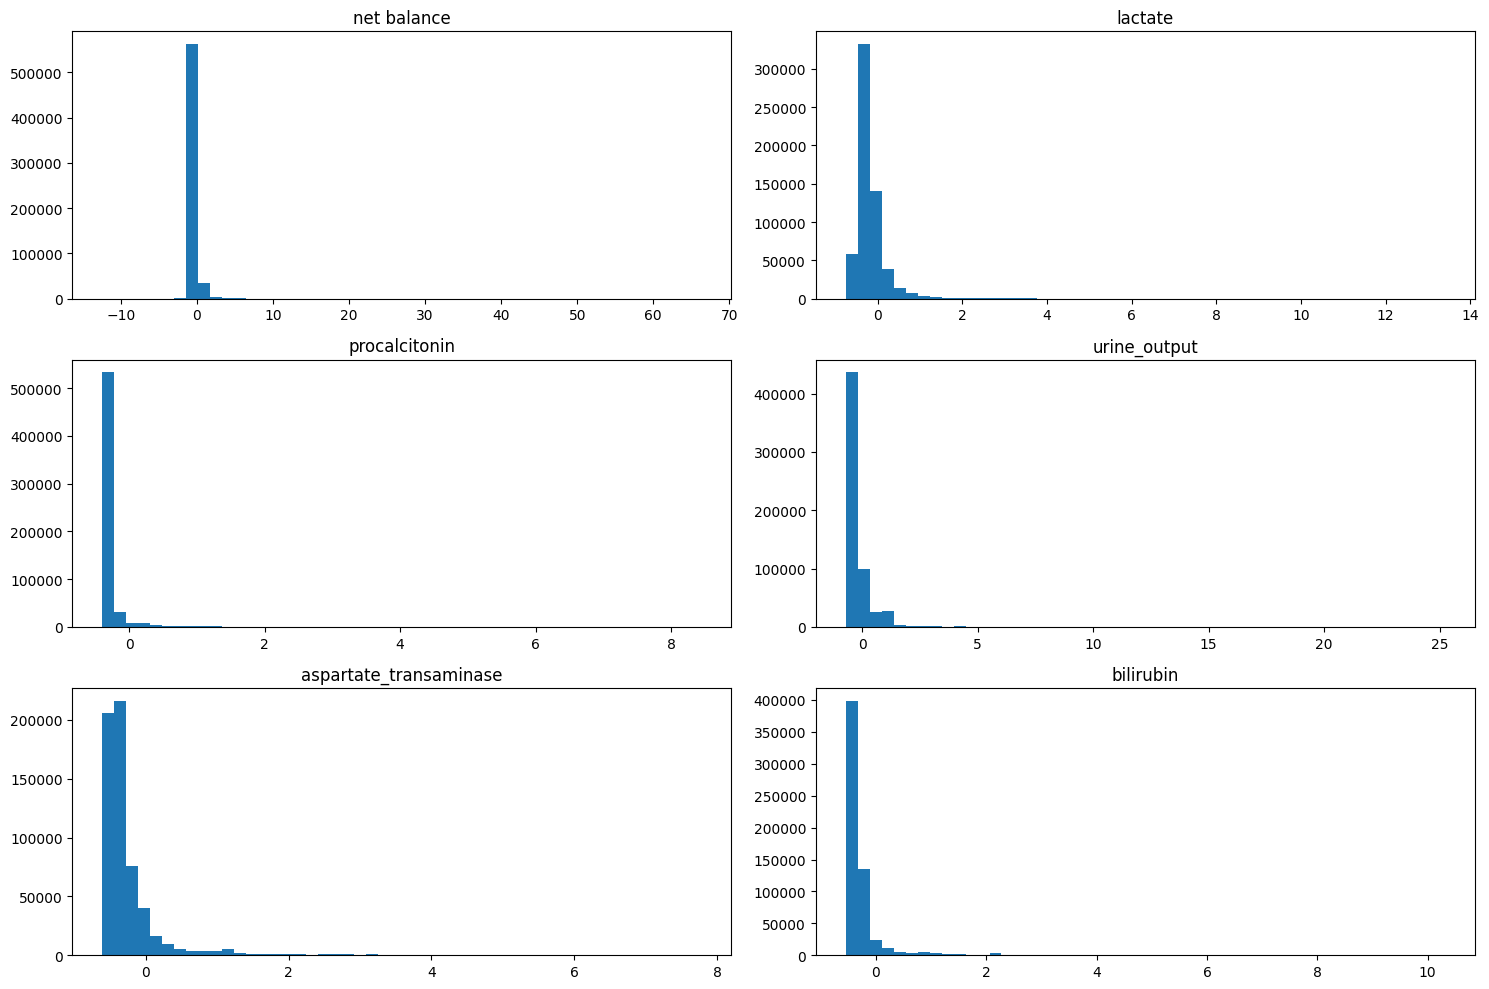

In [17]:
import matplotlib.pyplot as plt

top_skewed = skew_df.abs().sort_values(by="skewness", ascending=False).head(6).index

plt.figure(figsize=(15, 10))

for i, col in enumerate(top_skewed):
    plt.subplot(3, 2, i+1)
    plt.hist(df[col], bins=50)
    plt.title(col)

plt.tight_layout()
plt.savefig("../Results/figures/top_skewed_histograms.png")
plt.show()


### Distribution & Skewness Summary

Several physiological variables exhibit strong positive skewness.

Most skewed features:
- net balance (25.55)
- lactate (9.60)
- procalcitonin (8.33)
- urine_output (7.55)
- aspartate_transaminase (5.87)
- bilirubin (5.69)
- quick_score (5.68)

Additionally, oxygen_saturation shows strong negative skew (-5.42).

Many laboratory markers have |skew| > 1, indicating non-Gaussian distributions
with long tails.

Histograms confirm heavy right-tailed behavior in multiple biomarkers,
especially inflammatory and metabolic markers.

## 6. Correlation Structure Analysis

Purpose:
To detect highly correlated laboratory features
and identify potential redundancy clusters.

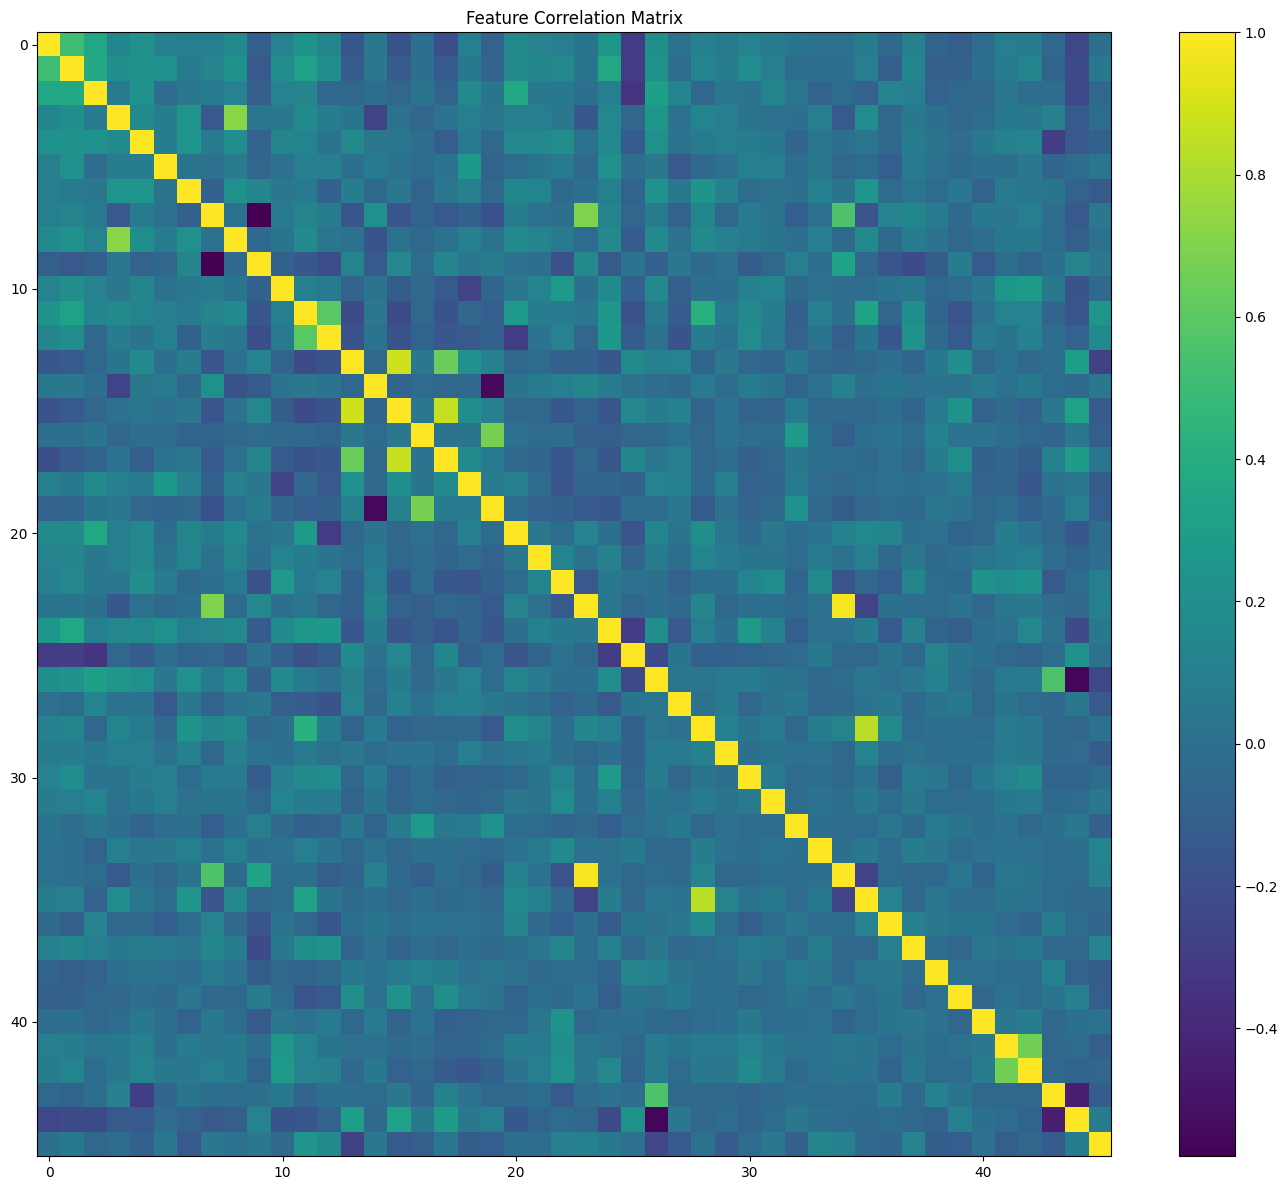

In [18]:
corr_matrix = df.drop(columns=['id']).corr()

plt.figure(figsize=(14, 12))
plt.imshow(corr_matrix, aspect='auto')
plt.colorbar()
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("../Results/figures/correlation_matrix.png")
plt.show()

In [19]:
# Extract upper triangle only
import numpy as np

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

strong_corr = (
    upper_triangle
    .stack()
    .reset_index()
)

strong_corr.columns = ['Feature_1', 'Feature_2', 'Correlation']

strong_corr = strong_corr[strong_corr['Correlation'].abs() > 0.8]

strong_corr.sort_values(by='Correlation', ascending=False)

,Feature_1,Feature_2,Correlation
792,bicarbonate,base_excess,0.980022
508,diastolic_bp,mean_bp,0.886711
571,mean_bp,systolic_bp,0.859511
888,sodium,chloride,0.834632


### Correlation Structure Summary

Most feature pairs exhibit low to moderate correlation.

Strong correlations (|r| > 0.8):

1. bicarbonate ↔ base_excess (r = 0.98)
2. diastolic_bp ↔ mean_bp (r = 0.89)
3. mean_bp ↔ systolic_bp (r = 0.86)
4. sodium ↔ chloride (r = 0.83)

These relationships are physiologically consistent:

- bicarbonate and base_excess both reflect acid-base balance.
- blood pressure components are mechanically related.
- sodium and chloride are electrolyte companions.

No large clusters of extreme multicollinearity were detected.

## 7. Patient-Level Sepsis Distribution

Purpose:
To evaluate class imbalance at the patient level,
since prediction is ultimately patient-centric.

In [20]:
# Patient-level label (since label is constant per patient)
patient_labels = (
    df.groupby('id')['sepsis']
    .first()
    .reset_index()
)

patient_counts = patient_labels['sepsis'].value_counts()

print("Patient-level Sepsis Distribution:")
print(patient_counts)

# Save table
patient_counts.to_csv("../Results/tables/patient_level_class_distribution.csv")


Patient-level Sepsis Distribution:
sepsis
0    979
1    296
Name: count, dtype: int64


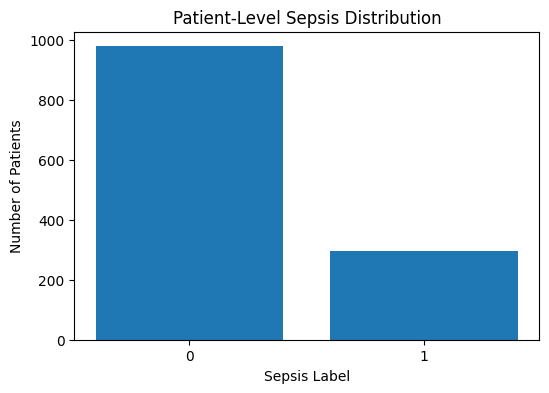

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(
    patient_counts.index.astype(str),
    patient_counts.values
)
plt.xlabel("Sepsis Label")
plt.ylabel("Number of Patients")
plt.title("Patient-Level Sepsis Distribution")
plt.savefig("../Results/figures/patient_level_class_distribution.png")
plt.show()


### Patient-Level Sepsis Distribution

Total patients: 1,275

- Non-septic patients (0): 979
- Septic patients (1): 296

This indicates class imbalance at the patient level:
Approximately 23% of patients are septic.

### Modeling Implication

Although row-level distribution appeared relatively balanced,
patient-level distribution reveals significant imbalance.

This is critical because:

- The prediction task is event-centric (sepsis onset).
- Model evaluation must consider imbalance-sensitive metrics
  such as recall, precision, and AUROC.
- Accuracy alone would be misleading.

Class imbalance handling strategies may be required during training
(e.g., class weighting or sampling).
